<a href="https://colab.research.google.com/github/L98S/weather_image_classification/blob/main/weather_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Introduction
Hello and welcome to a new data science project, one that I'm excited to work on because it involves images! Yes, my friend, we are diving into image classification, specifically focusing on weather images.

The field of computer vision is rapidly expanding and finds applications in a variety of fields, from medicine to the military. Today, we're going to apply it to weather and classify images of different types of weather. In this project, we aim to achieve the following objectives:

* 1- Conduct an exploratory data analysis (EDA) to understand the dataset.
* 2- Develop and evaluate a multi-class classification model to identify the weather condition in each image.
* 3- Develop an API to serve the model, making it accessible for real-world applications.



---

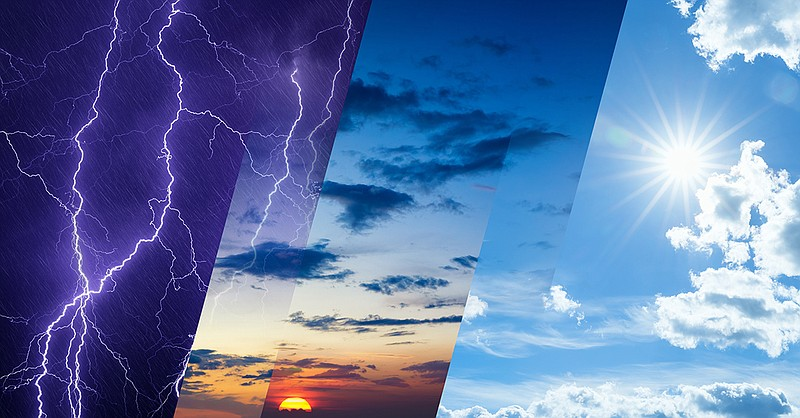

---

## About The Data
This data is obtained from Kaggle and contains 6,862 images of different types of weather. The pictures are divided into 11 classes.

* 1-dew
* 2-fog/smog
* 3-frost
* 4-glaze
* 5-hail
* 6-lightning
* 7-rain
* 8-rainbow
* 9-rime
* 10-sandstorm
* 11-snow

# 2.Load The Data
we can access the data from Kaggle by following the code below.

In [ ]:
# Import the required libraries
import os
from getpass import getpass

# Prompt the user to enter their Kaggle username
# The getpass function hides the input for security reasons
os.environ['KAGGLE_USERNAME'] = getpass('Enter your Kaggle username: ')

# Prompt the user to enter their Kaggle API key
# Again, the getpass function is used to hide the input for security
os.environ['KAGGLE_KEY'] = getpass('Enter your Kaggle API key: ')


Enter your Kaggle username: ··········
Enter your Kaggle API key: ··········


In [ ]:
# downloading the data
!kaggle datasets download -d jehanbhathena/weather-dataset

 96% 563M/587M [00:03<00:00, 137MB/s]
100% 587M/587M [00:03<00:00, 165MB/s]


As you can see, the data has been downloaded in a zip file, so the next thing we should do is unzip the file

In [ ]:
# Import the ZipFile class from the zipfile module
from zipfile import ZipFile

# Specify the path to the zip file you want to unzip
file_name = '/content/weather-dataset.zip'

# Open the zip file in read mode ('r')
with ZipFile(file_name, 'r') as zip1:

  # Extract all the contents of the zip file into the current directory
  zip1.extractall()

  # Print a message to indicate that the files have been successfully extracted
  print('Done')


Done


We now have 11 folders, each containing images corresponding to a specific weather condition. Let's first count the number of images in each category to get an idea of the class distribution. This is crucial for determining whether there is any data imbalance, which will inform how we should split our data

In [ ]:
import plotly.express as px
import os

In [ ]:
weather_conditions = os.listdir('/content/dataset')

# Initialize a dictionary to hold the count of images for each condition
image_counts = {}

# Count the number of images for each weather condition
for condition in weather_conditions:
    image_counts[condition] = len(os.listdir(os.path.join('/content/dataset', condition)))

# Sort the dictionary by values (number of images)
sorted_image_counts = {k: v for k, v in sorted(image_counts.items(), key=lambda item: item[1] , reverse=True)}

# Create a count plot with sorted values
fig = px.bar(
    x=list(sorted_image_counts.keys()),
    y=list(sorted_image_counts.values()),
    labels={'x': 'Weather Condition', 'y': 'Number of Images'},
    title='Number of Images Per Weather Condition'
)
fig.show()

By exsamining the countplot there does appear to be some level of class imbalance. The number of images varies significantly across different weather conditions, ranging from as low as 232 for "rainbow" to as high as 1160 for "rime

### 2.1-initial cleaning
Before moving on we're going to identify unreadable or problematic images so we can investigate them and deal with them

In [ ]:
import cv2

def clean_data(folder_path):
    # Extracting unreadable images
    for folder in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, folder)
        for img_name in os.listdir(sub_folder_path):
            img_path = os.path.join(sub_folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Unreadable image detected at {img_path}")
            # Extracting images that have a different extension than 'jpg'
            _, ext = os.path.splitext(img_path)
            ext = ext[1:]
            if ext.lower() != 'jpg':
                print(f"Image not in ext list {image_path}")

clean_data('/content/dataset')

Unreadable image detected at /content/dataset/snow/1187.jpg
Unreadable image detected at /content/dataset/fogsmog/4514.jpg


Since there are only two images, we can manually open them and investigate the problem. After doing that, you'll realize that these are not images but animations, which could cause issues for us in the future. Therefore, the best approach is to remove them.

In [ ]:
os.remove('/content/dataset/snow/1187.jpg')
os.remove('/content/dataset/fogsmog/4514.jpg')

# 3.Split The Data
As always we split our data at the very beginning. In imbalanced datasets, there's a risk that random splitting might result in subsets that don't accurately represent the overall class distribution. To enure that the train and test sets have the same proportion of each class as in the full dataset we'll apply stratified sampling.

In [ ]:
from sklearn.model_selection import train_test_split
import shutil

# Directory names for train and test data
train_dir = './train_data'
test_dir = './test_data'

# Create the directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Initialize lists to hold image paths and their corresponding labels
all_image_paths = []
all_image_labels = []

# Populate the lists
for condition in image_counts.keys():
    condition_path = os.path.join('/content/dataset', condition)
    image_paths = [os.path.join(condition_path, filename) for filename in os.listdir(condition_path)]
    all_image_paths.extend(image_paths)
    all_image_labels.extend([condition] * len(image_paths))

# Perform stratified sampling
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_image_labels, test_size=0.2, stratify=all_image_labels, random_state=42
)

# Function to move files
def move_files(file_paths, destination_folder, labels):
    for file_path, label in zip(file_paths, labels):
        dest_path = os.path.join(destination_folder, label)
        os.makedirs(dest_path, exist_ok=True)
        shutil.move(file_path, os.path.join(dest_path, os.path.basename(file_path)))

# Move the files to the respective train and test directories
move_files(train_paths, train_dir, train_labels)
move_files(test_paths, test_dir, test_labels)

Now we are ready to explore the data further, let's move on to Exploratory Data Analysis


# 4.Exploratory Data Analysis

### 4.1-Sample Images Visualization


While it's easy to manually click and view individual images from each folder, let's ues the power of coding to display images from each class. This will give us a better sense of what the images look like

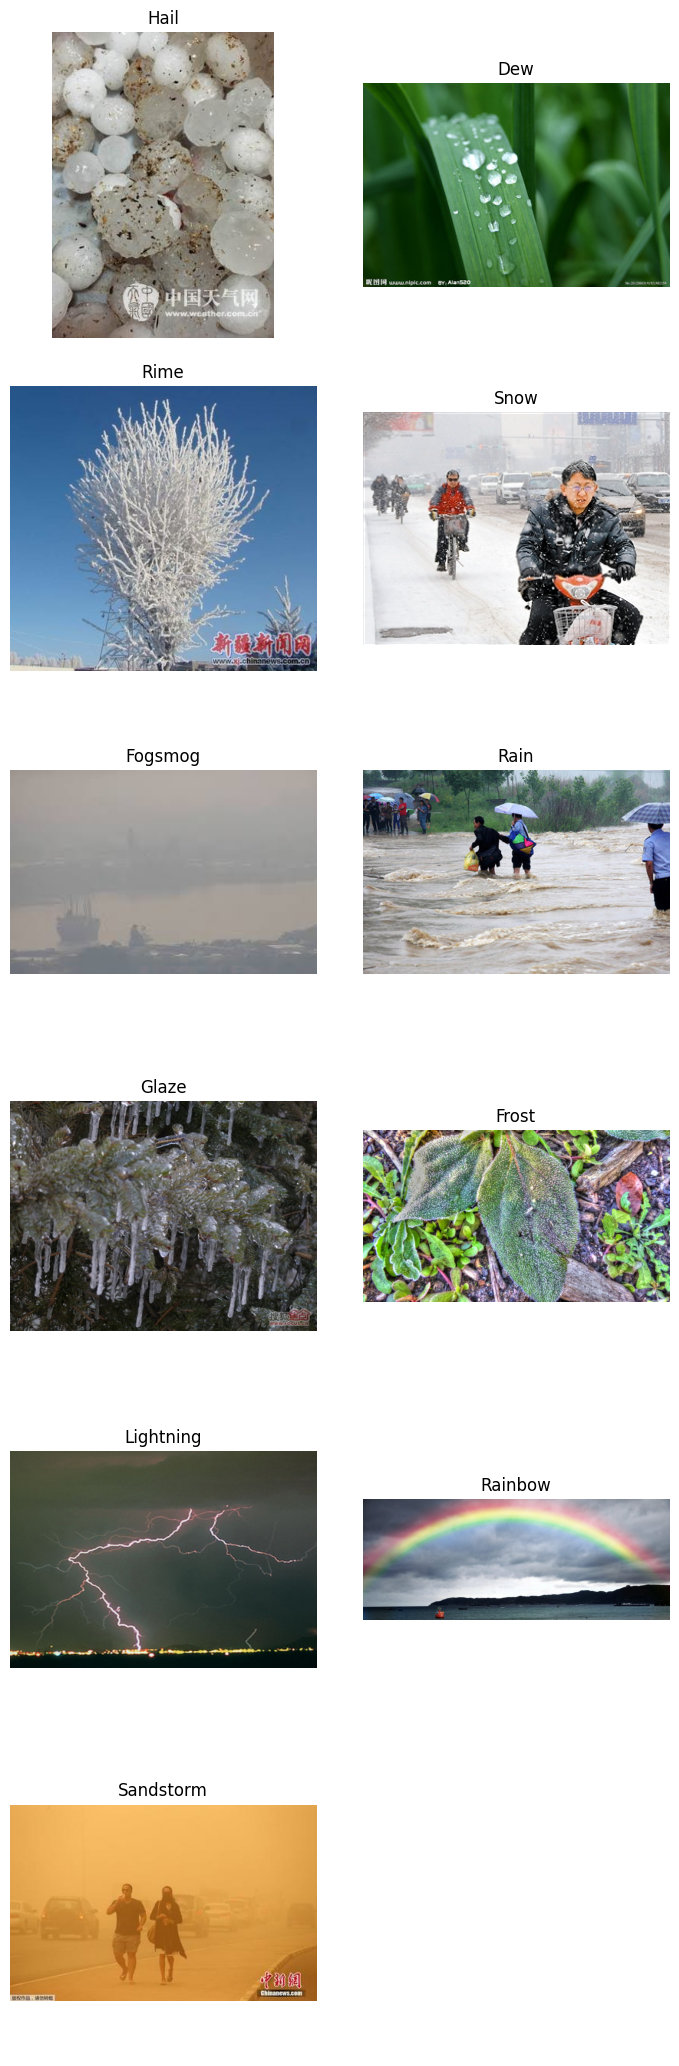

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(7, 21))
plt.subplots_adjust(wspace=0)
ax = axes.flatten()
cls_dist = {}

train_dir = "/content/train_data"

# Loop through each folder in the training data directory
for i, weather in enumerate(os.listdir(train_dir)):
    label = weather
    imgs = os.listdir(os.path.join(train_dir, weather))
    cls_dist[label] = len(imgs)

    # Read the first image from the list
    img_path = os.path.join(train_dir, weather, imgs[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    # Display the image in the ith subplot
    ax[i].imshow(img)
    ax[i].set_title(f"{label.capitalize()}")
    ax[i].axis("off")

plt.tight_layout()
plt.axis("off")
plt.show()

After checking out the images, it's clear they're full of color and details. This means we'll probably need a complex model to understand all these complex features. Also, the images have different dimensions. which is important to note because many machine learning models, especially neural networks, require that all input samples have the same dimensions.

### 4.2-Image Size Distribution
Understanding the distribution of image sizes can help us decide how to preprocess the images for the model. Many machine learning algorithms require input images to have the same dimensions. Knowing the size distribution of images can guide the resizing strategy

In [ ]:
# Initialize lists to store heights and widths
heights = []
widths = []

# Loop through each folder in the training directory
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)

    # Loop through each image in the folder
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Read the image using OpenCV
        img = cv2.imread(image_path)

        # Get the shape of the image and append height and width to lists
        h, w, _ = img.shape
        heights.append(h)
        widths.append(w)



# Create a DataFrame for easy plotting
import pandas as pd
df = pd.DataFrame({
    'Height': heights,
    'Width': widths
})

# Create the subplots for heights and widths
fig = px.histogram(df, x="Height", nbins=50, title="Distribution of Image Heights")
fig.show()

fig = px.histogram(df, x="Width", nbins=50, title="Distribution of Image Widths")
fig.show()

As we can see, the height of most images is between 200-400 pixels and the width is between 400-500 pixels. Looking at this we could resize all images to a common dimension that falls within these ranges, such as 250x250 pixels, to ensure minimal loss of information for the majority of images.

Note that larger images require more computational power and memory, which can slow down the training process. we want to strik a balance between reducing the image dimensions to make the computations more efficient, and preserving enough detail so that the model can still learn the important features for accurate classification.

### 4.3-Color Distribution
Analyzing the distribution of color intensities in the images can help us understand if color is a significant feature for classifying weather conditions which might give insights into whether converting to grayscale would be beneficial.

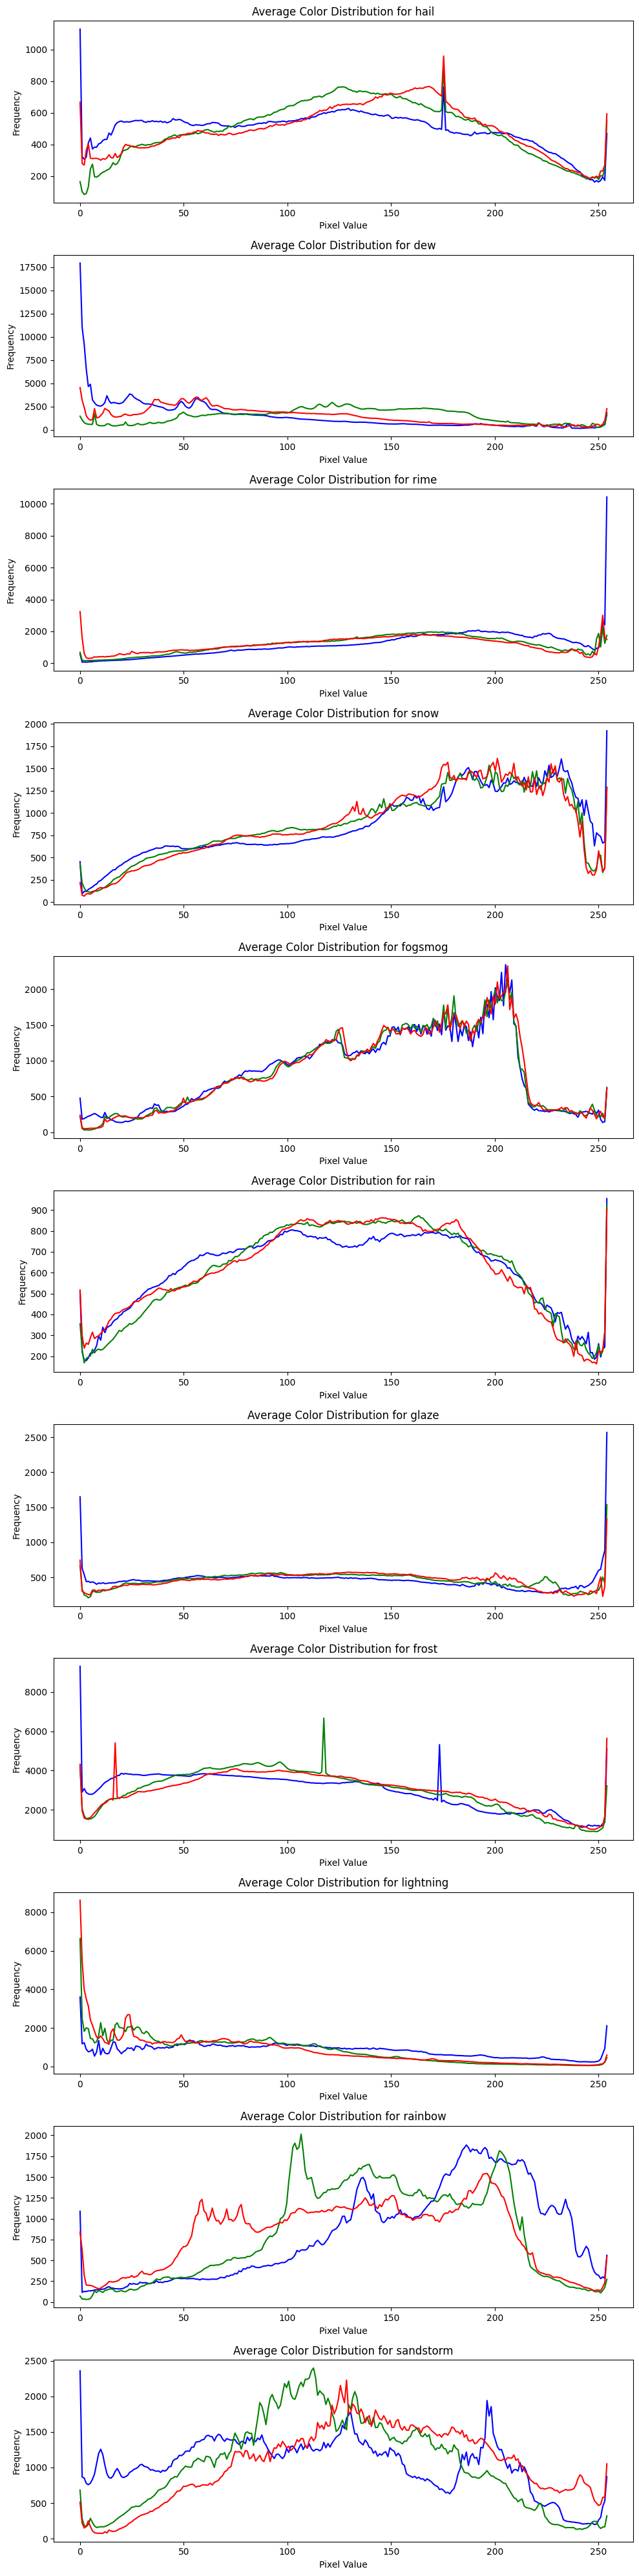

In [ ]:
import numpy as np
import random

# Define the colors
colors = ('b', 'g', 'r')

# Initialize plot
fig, axes = plt.subplots(len(os.listdir(train_dir)), 1, figsize=(10, 40))

# Loop through each folder in the training directory
for ax, folder in zip(axes, os.listdir(train_dir)):
    folder_path = os.path.join(train_dir, folder)

    # Randomly select a few images (e.g., 100) from the folder
    sample_images = random.sample(os.listdir(folder_path), 100)

    # Initialize histogram data
    hist_data = { 'b': [], 'g': [], 'r': [] }

    for image_name in sample_images:
        image_path = os.path.join(folder_path, image_name)

        # Read the image
        img = cv2.imread(image_path)

        # Calculate histogram for each color channel
        for i, color in enumerate(colors):
            histogram, bin_edges = np.histogram(
                img[:, :, i], bins=256, range=(0, 255)
            )
            hist_data[color].append(histogram)

    # Average the histograms from the sample images
    for color in colors:
        avg_hist = np.mean(hist_data[color], axis=0)
        ax.plot(bin_edges[0:-1], avg_hist, color=color)

    # Configure and show plot
    ax.set_title(f"Average Color Distribution for {folder}")
    ax.set_xlabel("Pixel Value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


As we can see the color distributions are clearly different among the classes in the histograms, that's a clue that color could be an important feature for our machine learning model. In such cases, converting the images to grayscale could result in a loss of important discriminative information.

# 5.Data Preprocessing
For this dataset, there are some important preprocessing steps that we need to do. I'll first explain the rationale behind each step before presenting the code.

### 5.1-Image Resizing
As we discussed earlier, resizing images so that they all have the same dimensions is necessary. For this project based on the EDA we performe we'll resize the images to 250x250.

### 5.2-Image Scaling
Scaling the pixel values to a range of 0-1 helps in speeding up the convergence of the model. This is because smaller values make it easier for the model to learn the weights, improving the training speed.

### 5.3-Label Encoding
Finally we're going to convert each unique string of the labels to a unique vectors (one-hot Encoding)

We'll build a pipeline for the preprocessing steps through the use of data generators, which efficiently handle the data in batches. This approach not only enhances computational performance but also effectively manages memory usage.

Note: You'll notice that one-hot encoding is not present in the pipeline. That's because the ImageDataGenerator automatically handles label encoding and one-hot encoding, eliminating the need for manual coding, we'll also need to create a validation set and since we're using ImageDataGenerator we can easily split off a validation set from the training data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Initialize the data generators, setting the validation_split in train_datagen
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # scaling the images
test_datagen = ImageDataGenerator(rescale=1./255)  # scaling the images

train_dir = '/content/train_data'
test_dir = '/content/test_data'

# For training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # specify this is training data
)

# For validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # specify this is validation data
)

# For test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)


Found 4394 images belonging to 11 classes.
Found 1094 images belonging to 11 classes.
Found 1372 images belonging to 11 classes.


# 6.Modeling and Evaluation
For this project, we'll be using neural networks and will experiment with different models, We'll compare their performances to identify the best one.

For evaluation, we'll use the following metrics:

* Accuracy: Measures the proportion of correct classifications. It's a good general indicator of model performance.
* Precision: It answers the question: Out of all the instances that the model labeled as positive, how many are actually positive?
* Recall: IT answers the question: "Out of all the actual positive instances, how many did the model correctly identify?"

These metrics will provide a comprehensive view of the model's performance. Let's go!

### 6.1-Simple CNN Model
We'll start with a basic Convolutional Neural Network (CNN) model.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3), kernel_regularizer='l2') )
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128 , (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(11))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'Precision', 'Recall'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping])

Epoch 1/30
137/137 [==============================] - 20s 132ms/step - loss: 2.0677 - accuracy: 0.3235 - precision: 0.7089 - recall: 0.1077 - val_loss: 1.5673 - val_accuracy: 0.5184 - val_precision: 0.8340 - val_recall: 0.1893
Epoch 2/30
137/137 [==============================] - 18s 133ms/step - loss: 1.6262 - accuracy: 0.4878 - precision: 0.7509 - recall: 0.2481 - val_loss: 1.3455 - val_accuracy: 0.5763 - val_precision: 0.8178 - val_recall: 0.3300
Epoch 3/30
137/137 [==============================] - 19s 136ms/step - loss: 1.3830 - accuracy: 0.5552 - precision: 0.7712 - recall: 0.3508 - val_loss: 1.2731 - val_accuracy: 0.5938 - val_precision: 0.7680 - val_recall: 0.4017
Epoch 4/30
137/137 [==============================] - 18s 133ms/step - loss: 1.2349 - accuracy: 0.5931 - precision: 0.7873 - recall: 0.4159 - val_loss: 1.1663 - val_accuracy: 0.6627 - val_precision: 0.8387 - val_recall: 0.4586
Epoch 5/30
137/137 [==============================] - 19s 135ms/step - loss: 1.1164 - accura

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc, test_precision, test_recall = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


42/42 [==============================] - 4s 104ms/step - loss: 1.1504 - accuracy: 0.6726 - precision: 0.7567 - recall: 0.5692
Test Loss: 1.150432825088501
Test Accuracy: 0.6726190447807312
Test Precision: 0.7566765546798706
Test Recall: 0.5691964030265808


Not bad, the model performs moderately well in terms of accuracy and precision but falls short in terms of recall. There is a huge room for improvement, so before trying another model, let's continue experimenting by adding more convolutional layers. This will increase complexity, possibly capturing new patterns. Of course, while doing this, we'll have to keep an eye on overfitting because as the model becomes more complex, it may start to learn noise from the training data rather than the underlying patterns we're interested in







In [ ]:
# Initialize the model
model2 = Sequential()

# First Convolutional Layer
model2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model2.add(MaxPooling2D(2, 2))

# Second Convolutional Layer
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(2, 2))

# Third Convolutional Layer
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(2, 2))

# Fourth Convolutional Layer
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(2, 2))

# Fifth Convolutional Layer
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D(2, 2))

# Fully connected layers
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(512, activation='relu'))

# Output layer
model2.add(Dense(11, activation='softmax'))

# Compile the model
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'Precision', 'Recall'])


In [ ]:
# Fit the model
history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping])

Epoch 1/30
137/137 [==============================] - 23s 137ms/step - loss: 2.2519 - accuracy: 0.2054 - precision: 0.6013 - recall: 0.0211 - val_loss: 2.1966 - val_accuracy: 0.2243 - val_precision: 1.0000 - val_recall: 0.0101
Epoch 2/30
137/137 [==============================] - 18s 132ms/step - loss: 1.9145 - accuracy: 0.3466 - precision: 0.6100 - recall: 0.0922 - val_loss: 1.7568 - val_accuracy: 0.4384 - val_precision: 0.7143 - val_recall: 0.1103
Epoch 3/30
137/137 [==============================] - 19s 138ms/step - loss: 1.6518 - accuracy: 0.4271 - precision: 0.6777 - recall: 0.2247 - val_loss: 1.5821 - val_accuracy: 0.4770 - val_precision: 0.6738 - val_recall: 0.3171
Epoch 4/30
137/137 [==============================] - 19s 141ms/step - loss: 1.4412 - accuracy: 0.5011 - precision: 0.7282 - recall: 0.3102 - val_loss: 1.4020 - val_accuracy: 0.5257 - val_precision: 0.7221 - val_recall: 0.3631
Epoch 5/30
137/137 [==============================] - 19s 138ms/step - loss: 1.3384 - accura

In [ ]:
test_loss, test_acc, test_precision, test_recall = model2.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

43/43 [==============================] - 5s 111ms/step - loss: 1.1855 - accuracy: 0.6224 - precision: 0.7146 - recall: 0.5583
Test Loss: 1.1854974031448364
Test Accuracy: 0.6224489808082581
Test Precision: 0.7145522236824036
Test Recall: 0.558309018611908


Overall, the metrics suggest that adding more layers in this case did not improve the model's performance. In fact, it seems to have slightly worsened it. This could be a sign that the added complexity is not beneficial for this project so we'll keep that in mind as we move on

### 6.2-DenseNet
Let's take advantage of pre-trained models; we can easily leverage a pre-trained DenseNet model from Keras and fine-tune it for our specific task

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Initialize the base model with pre-trained weights and exclude the top layer
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Add final prediction layer with 11 output classes
predictions = Dense(11, activation='softmax')(x)

# Create the final model
model3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

# Train the model
model3.fit(train_generator,
          epochs=30,
          validation_data=validation_generator,
          callbacks=[early_stopping])


Epoch 1/30
138/138 [==============================] - 136s 275ms/step - loss: 1.0942 - accuracy: 0.6573 - precision: 0.7708 - recall: 0.5640 - val_loss: 8.4948 - val_accuracy: 0.4241 - val_precision: 0.4340 - val_recall: 0.4205
Epoch 2/30
138/138 [==============================] - 35s 253ms/step - loss: 0.6655 - accuracy: 0.7852 - precision: 0.8451 - recall: 0.7249 - val_loss: 5.8841 - val_accuracy: 0.4561 - val_precision: 0.4652 - val_recall: 0.4397
Epoch 3/30
138/138 [==============================] - 35s 252ms/step - loss: 0.5754 - accuracy: 0.8141 - precision: 0.8626 - recall: 0.7601 - val_loss: 2.1840 - val_accuracy: 0.4762 - val_precision: 0.4969 - val_recall: 0.4342
Epoch 4/30
138/138 [==============================] - 35s 252ms/step - loss: 0.4856 - accuracy: 0.8427 - precision: 0.8792 - recall: 0.8068 - val_loss: 2.1139 - val_accuracy: 0.5859 - val_precision: 0.6154 - val_recall: 0.5484
Epoch 5/30
138/138 [==============================] - 35s 253ms/step - loss: 0.3787 - accur

In [ ]:
test_loss, test_acc, test_precision, test_recall = model3.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

43/43 [==============================] - 5s 110ms/step - loss: 1.0093 - accuracy: 0.7507 - precision: 0.7699 - recall: 0.7318
Test Loss: 1.0092581510543823
Test Accuracy: 0.7507288455963135
Test Precision: 0.7699386477470398
Test Recall: 0.7317784428596497


Looking at this model we can see that it doesn't exhibit classic overfitting symptoms like a constant decrease in training loss coupled with an increase in validation loss. However, it does seem to struggle with generalization, given the high validation loss and fluctuating validation metrics. At this point we might want to consider techniques to improve generalization, such as adding dropout layers, using data augmentation, or applying regularization.

In [ ]:
from tensorflow.keras.regularizers import l1, l2

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load pre-trained DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# First, freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer and a logistic layer with 11 classes
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(11, activation='softmax')(x)

# The model to be trained
model4 = Model(inputs=base_model.input, outputs=predictions)

model4.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

model4.fit(train_generator,
          epochs=5,
          validation_data=validation_generator)

# Unfreeze some layers in the base model
N = 45  # The number of layers we want to unfreeze
for layer in base_model.layers[-N:]:
    layer.trainable = True

# Recompile the model for the changes to take effect with a lower learning rate
model4.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

# Train the model again
model4.fit(train_generator,
          epochs=200,
          validation_data=validation_generator,
          callbacks=[early_stopping]
)

Epoch 1/5
138/138 [==============================] - 32s 163ms/step - loss: 10.5311 - accuracy: 0.1234 - precision: 0.1260 - recall: 0.0071 - val_loss: 9.8238 - val_accuracy: 0.2706 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
138/138 [==============================] - 19s 138ms/step - loss: 9.6732 - accuracy: 0.2531 - precision: 0.4509 - recall: 0.0282 - val_loss: 9.1199 - val_accuracy: 0.4488 - val_precision: 0.7143 - val_recall: 0.0091
Epoch 3/5
138/138 [==============================] - 20s 141ms/step - loss: 9.0120 - accuracy: 0.3694 - precision: 0.6335 - recall: 0.0680 - val_loss: 8.5253 - val_accuracy: 0.5585 - val_precision: 0.9022 - val_recall: 0.0759
Epoch 4/5
138/138 [==============================] - 19s 138ms/step - loss: 8.4408 - accuracy: 0.4650 - precision: 0.7303 - recall: 0.1288 - val_loss: 8.0080 - val_accuracy: 0.6188 - val_precision: 0.9158 - val_recall: 0.1691
Epoch 5/5
138/138 [==============================] - 19s 137ms/step - loss: 7.9525 - ac

In [ ]:
test_loss, test_acc, test_precision, test_recall = model4.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

43/43 [==============================] - 5s 108ms/step - loss: 0.3200 - accuracy: 0.9213 - precision: 0.9345 - recall: 0.9155
Test Loss: 0.32004955410957336
Test Accuracy: 0.9212828278541565
Test Precision: 0.9345238208770752
Test Recall: 0.9154518842697144


Now that's a solid model! There's a lot going on in this code, so I've broken down each step and its benefit to the overall model as follows:

* Image Data Generator:
   *  Increases the effective size of the training set.
   *  Helps the model generalize better by introducing variability in the training data.
* Freezing Base Model Layers
  * Allows for focused training on the new layers, saving computational resources.
*  L2 regularization:
  * Helps to prevent overfitting by penalizing large weights.
* Dropout layer:
  * Also combats overfitting by randomly setting a fraction of input units to 0 at each update during training.
*  Recompile:
   * Necessary for applying changes like unfreezing layers and modifying the learning rate for subsequent training.


Note: I've tweaked, ran, and reran this model multiple times to arrive at the optimal settings. However, for the sake of brevity and clarity, this notebook only includes two key versions: the initial one ("model3") and the final, refined version ("model4")

### 6.3-Final model:
Now as a final step we need to save our model

In [ ]:
model4.save('model4.h5')

# 7.Conclusion
this project showcased the process of building and deploying a convolutional neural network for weather image classification, a variety of models were experimented with and we settled on a robust model that not only offered high accuracy but also maintained a balance between precision and recall.
I hope you enjoy exploring this project as much as I did.
See you in the next project!